In [1]:
install.packages('tidyr')

also installing the dependencies 'glue', 'rlang', 'tibble', 'pillar', 'dplyr', 'lifecycle', 'tidyselect'




  There are binary versions available but the source versions are later:
          binary source needs_compilation
glue       1.4.2  1.6.0              TRUE
rlang     0.4.11 0.4.12              TRUE
tibble     3.1.1  3.1.6              TRUE
pillar     1.6.0  1.6.4             FALSE
dplyr      1.0.6  1.0.7              TRUE
lifecycle  1.0.0  1.0.1             FALSE
tidyr      1.1.3  1.1.4              TRUE

  Binaries will be installed
package 'glue' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked
package 'tibble' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked
package 'tidyselect' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Martin\AppData\Local\Temp\RtmpcnXELg\downloaded_packages


installing the source packages 'pillar', 'lifecycle'



In [32]:
library("dplyr")
library("tidyverse")
library("knitr")
library("rmarkdown")
library("lubridate")
library("ggplot2")

In [33]:
# read in data csv file
df <- read.csv("C:/Users/Martin/Desktop/Datasets/forestfires.csv")
head(df)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


In [84]:
# check rows and columns
glimpse(df)

Rows: 517
Columns: 13
$ X     <int> 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 8, 6, 6, 6, 5~
$ Y     <int> 5, 4, 4, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4~
$ month <fct> mar, oct, oct, mar, mar, aug, aug, aug, sep, sep, sep, sep, aug,~
$ day   <fct> fri, tue, sat, fri, sun, sun, mon, mon, tue, sat, sat, sat, fri,~
$ FFMC  <dbl> 86.2, 90.6, 90.6, 91.7, 89.3, 92.3, 92.3, 91.5, 91.0, 92.5, 92.5~
$ DMC   <dbl> 26.2, 35.4, 43.7, 33.3, 51.3, 85.3, 88.9, 145.4, 129.5, 88.0, 88~
$ DC    <dbl> 94.3, 669.1, 686.9, 77.5, 102.2, 488.0, 495.6, 608.2, 692.6, 698~
$ ISI   <dbl> 5.1, 6.7, 6.7, 9.0, 9.6, 14.7, 8.5, 10.7, 7.0, 7.1, 7.1, 22.6, 0~
$ temp  <dbl> 8.2, 18.0, 14.6, 8.3, 11.4, 22.2, 24.1, 8.0, 13.1, 22.8, 17.8, 1~
$ RH    <int> 51, 33, 33, 97, 99, 29, 27, 86, 63, 40, 51, 38, 72, 42, 21, 44, ~
$ wind  <dbl> 6.7, 0.9, 1.3, 4.0, 1.8, 5.4, 3.1, 2.2, 5.4, 4.0, 7.2, 4.0, 6.7,~
$ rain  <dbl> 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,~
$ area  <dbl> 0, 0

Each row represents the location, day, and month of the following variables during a forest fire.

**`FFMC`** - The Fine Fuel Moisture Code which represents the fuel moisture of forest litter fuels under the shade of the forest canopy.

**`DMC`** - The Duff Moisture Code. The average moisture content of loosely compacted organic layers of moderate depth.

**`DC`** - The Drought Code. The average moisture content of deep, compact organic layers.

**`ISI`** - The Initial Spread Index. The expected rate of fire spread.

**`RH`** - Relative Humidity. How much water vapor is in the air, compared to how much there could be.

**`Temp`** - Temperature in Celsius Degrees

**`Wind`** - Wind speed in km/h

**`Rain`** - Outside Rain in mm/m2

**`Area`** - The burned area of the forest in hectares.

## Categorize The Month And Day Columns In Order


In [85]:
# check unique month values
df %>% pull(month) %>% unique

[1] mar oct aug sep apr jun jul feb jan dec may nov
Levels: jan feb mar apr may jun jul aug sep oct nov dec

In [86]:
# check unique day values
df %>% pull(day) %>% unique

[1] fri tue sat sun mon wed thu
Levels: mon tue wed thu fri sat sun

In [87]:
# order month and day values and create factors
month_order <- c('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec')

day_order <- c('mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun')

df <- df %>% mutate(
  month = factor(month, levels = month_order),
  day = factor(day, levels = day_order)
)

## What Months Do Fires Occur Most?



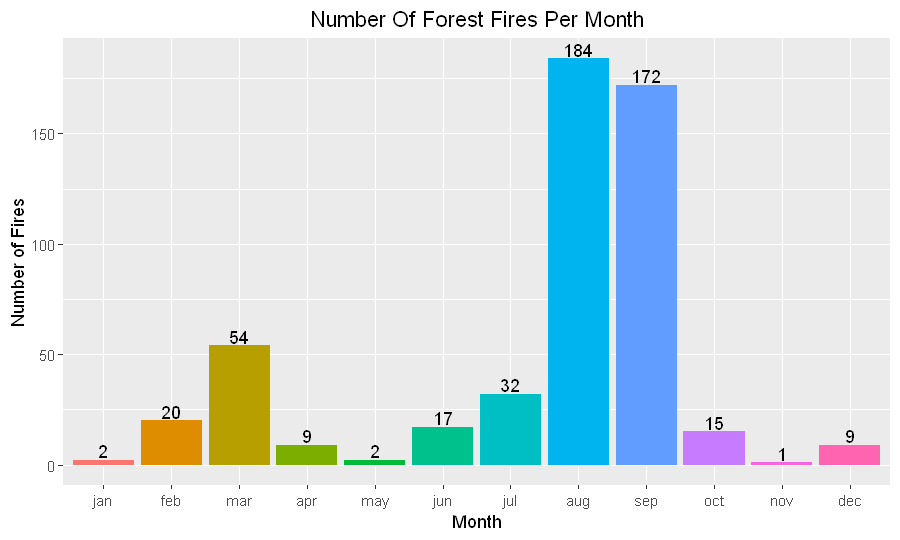

In [106]:
# create dataframe grouped by month, then count number of fires (rows)
fires_per_month <- df %>% group_by(month) %>%
  summarize(total_fires = n())

# create column graph for the number of fires per month
options(repr.plot.width = 7.5, repr.plot.height = 4.5)
fires_per_month %>%
  ggplot(aes(x = month, y = total_fires, fill = month)) +
  geom_col() +
  geom_text(aes(label = total_fires), vjust = -0.2) +
  labs(
    title = 'Number Of Forest Fires Per Month',
    x = 'Month',
    y = 'Number of Fires'
  ) +
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

August and September stand out as having the most forest fires. January, May, and November have the least forest fires.

## What Week Days Do Forest Fires Occur The Most?


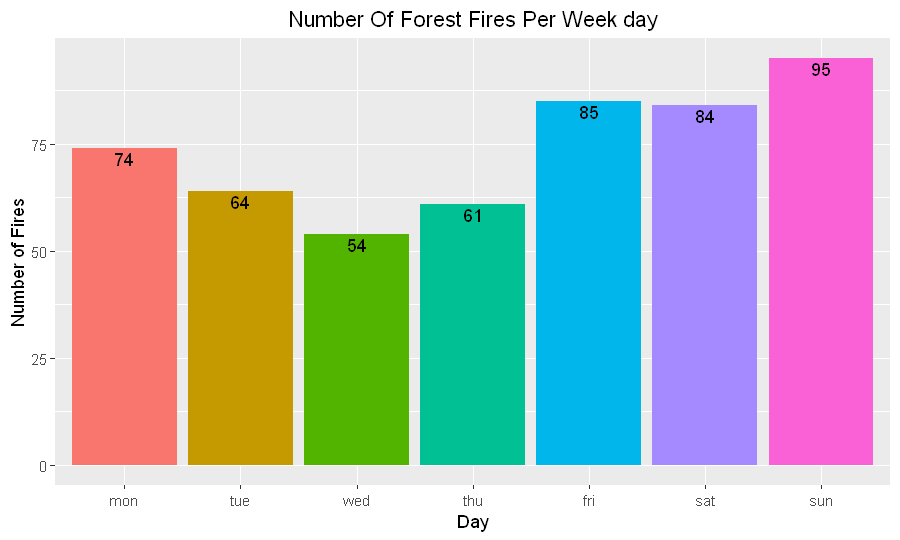

In [89]:
# create dataframe grouped by day, then count number of fires (rows)
fires_per_day <- df %>% group_by(day) %>%
  summarise(total_fires = n())

# create column graph for the number of fires per week day
fires_per_day %>%
  ggplot(aes(x = day, y = total_fires, fill = day)) +
  geom_col() +
  geom_text(aes(label = total_fires), vjust = 1.2) +
  labs(
    title = 'Number Of Forest Fires Per Week day',
    x = 'Day',
    y = 'Number of Fires'
  ) +
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

The data shows Sunday has the most forest fires and Wednesday has the least. Friday, Saturday, and Sunday have more than the other weekdays.

## Check How Data Variables Relate To Month And Day

Variables;

* FFMC
* DMC
* DC
* ISI
* temp
* RH
* wind
* rain


In [56]:
# create a dataframe in long format
df_long <- df %>% pivot_longer(
  cols = c(FFMC, DMC, DC, ISI, temp, RH, wind, rain),
  names_to = 'variable',
  values_to = 'value'
)
head(df_long, 10)

X,Y,month,day,area,variable,value
7,5,mar,fri,0,FFMC,86.2
7,5,mar,fri,0,DMC,26.2
7,5,mar,fri,0,DC,94.3
7,5,mar,fri,0,ISI,5.1
7,5,mar,fri,0,temp,8.2
7,5,mar,fri,0,RH,51.0
7,5,mar,fri,0,wind,6.7
7,5,mar,fri,0,rain,0.0
7,4,oct,tue,0,FFMC,90.6
7,4,oct,tue,0,DMC,35.4


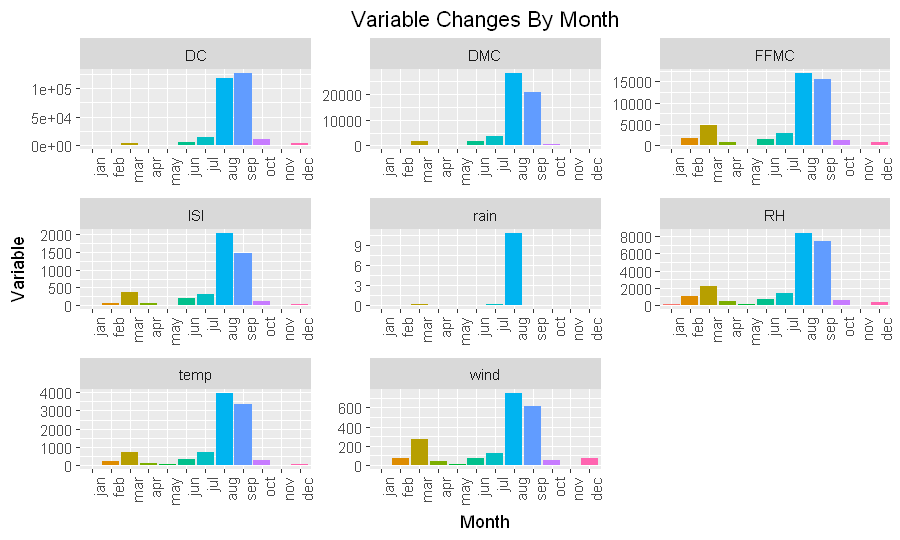

In [110]:
# create column graphs for each variable value by month
df_long %>%
  ggplot(aes(x = month, y = value, fill = month)) +
  geom_col() +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Variable Changes By Month',
    x = 'Month',
    y = 'Variable'
  ) +
  theme(legend.position='none', plot.title=element_text(hjust=0.5), axis.text.x=element_text(angle=90, hjust=1))

All variables show increased values during August and September (except rain during September). No variable stands out over the others during August and September.



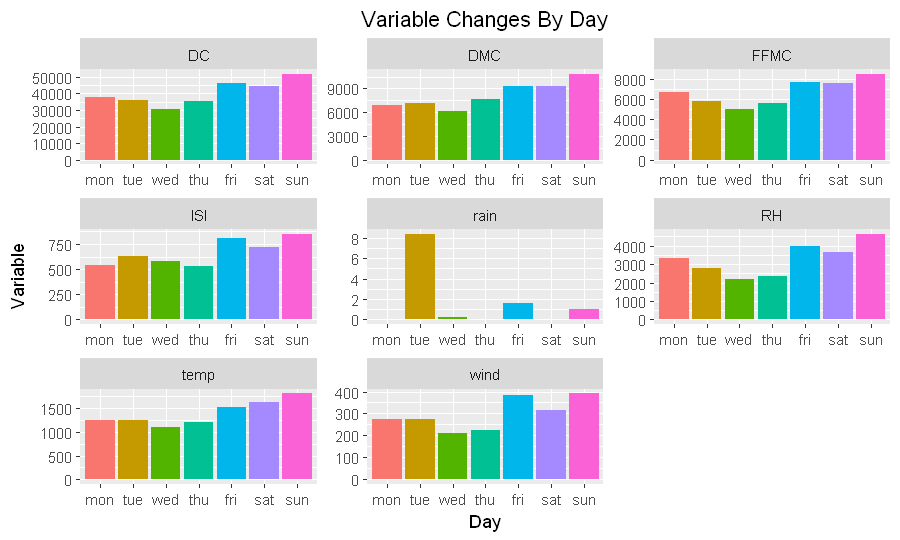

In [91]:
# create column graphs for each variable value by week day
df_long %>%
  ggplot(aes(x = day, y = value, fill = day)) +
  geom_col() +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Variable Changes By Day',
    x = 'Day',
    y = 'Variable'
  ) +
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

Again, all variables show increased values on Friday, Saturday, and Sunday when forest fires are most prevalent, except for rain.

## Check If The Variables Affect Area

Assume that Area can be used to describe the severity or intensity of the fire.


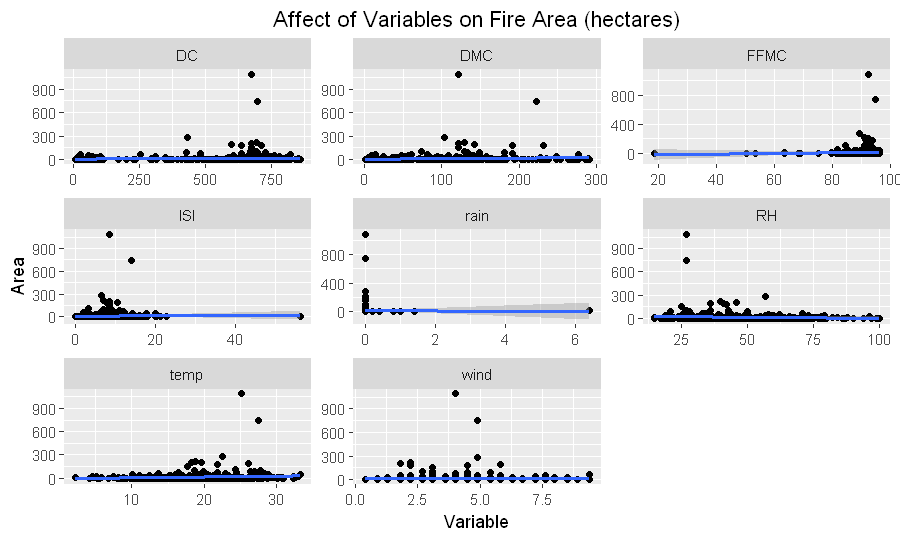

In [92]:
# create column graphs for how area is affected by the variable values
df_long %>%
  ggplot(aes(x = value, y = area)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Affect of Variables on Fire Area (hectares)',
    x = 'Variable',
    y = 'Area'
  ) + 
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

There is no correlation between the variables and area.

## Check For Outliers in Area


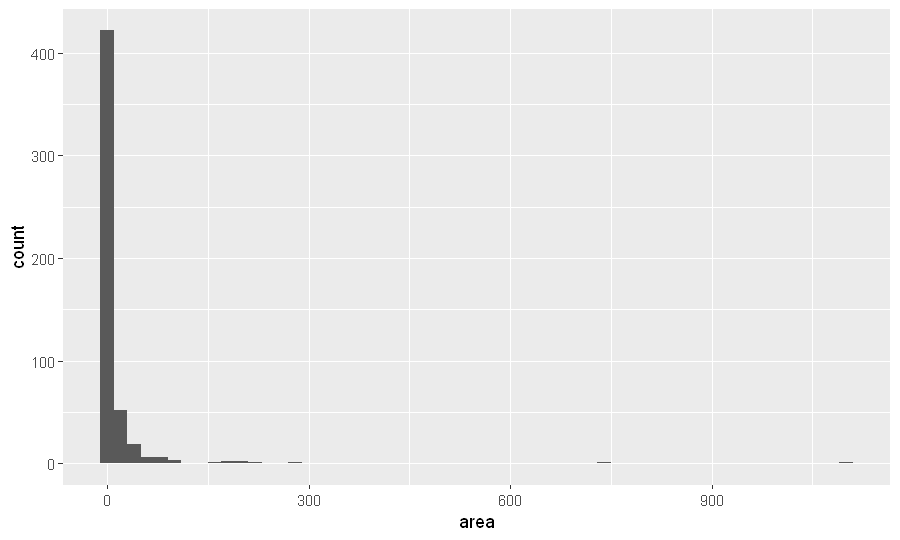

In [95]:
# create a histogram for the area column
df %>% 
  ggplot(aes(x = area)) +
  geom_histogram(binwidth = 20)

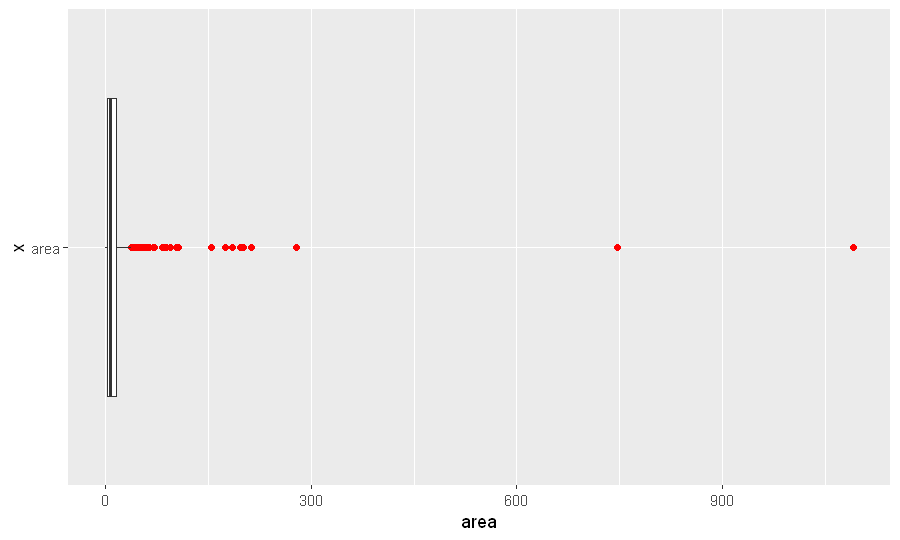

In [96]:
# create a boxplot for the area column
area_count_df <- df %>%
    group_by(area) %>%
    summarise(count = n())

area_count_df %>%
  ggplot(aes(x = 'area', y = area)) +
  geom_boxplot(outlier.color = 'Red') +
  coord_flip()

In [97]:
# the five number summary
fivenum(df$area)

[1]    0.00    0.00    0.52    6.57 1090.84

In [98]:
# interquartile range
iqr <- IQR(df$area)
iqr

[1] 6.57

In [99]:
# high outliers 
outliers <- 6.57 + (1.5 * iqr)
outliers

[1] 16.425

In [100]:
# unique values in the area column
df %>% pull(area) %>% unique

[1]    0.00    0.36    0.43    0.47    0.55    0.61    0.71    0.77    0.90
 [10]    0.95    0.96    1.07    1.12    1.19    1.36    1.43    1.46    1.56
 [19]    1.61    1.63    1.64    1.69    1.75    1.90    1.94    1.95    2.01
 [28]    2.14    2.29    2.51    2.53    2.55    2.57    2.69    2.74    3.07
 [37]    3.50    4.53    4.61    4.69    4.88    5.23    5.33    5.44    6.38
 [46]    6.83    6.96    7.04    7.19    7.30    7.40    8.24    8.31    8.68
 [55]    8.71    9.41   10.01   10.02   10.93   11.06   11.24   11.32   11.53
 [64]   12.10   13.05   13.70   13.99   14.57   15.45   17.20   19.23   23.41
 [73]   24.23   26.00   26.13   27.35   28.66   29.48   30.32   31.72   31.86
 [82]   32.07   35.88   36.85   37.02   37.71   48.55   49.37   58.30   64.10
 [91]   71.30   88.49   95.18  103.39  105.66  154.88  196.48  200.94  212.88
[100] 1090.84   10.13    2.87    0.76    0.09    0.75    2.47    0.68    0.24
[109]    0.21    1.52   10.34    8.02    1.38    8.85    3.30    4.25    6.54
[118]    0.79    0.17    4.40    0.52    9.27    3.09    8.98   11.19    5.38
[127]   17.85   10.73   22.03    9.77   24.77    1.10   24.24    8.00    2.64
[136]   86.45    6.57    3.52    0.41    5.18   14.29    1.58    3.78    4.41
[145]   34.36    7.21    1.01    2.18    4.42    3.33    6.58   15.64   11.22
[154]    2.13   56.04    7.48    1.47    3.93    6.10    5.83   28.19    3.71
[163]    7.31    2.03    1.72    5.97   13.06    1.26    8.12    1.09    3.94
[172]    2.93    5.65   20.03   12.64   18.30   39.35  174.63    7.73   16.33
[181]    5.86   42.87   12.18   16.00   24.59   28.74    9.96   30.18   70.76
[190]   51.78    3.64    3.63    8.16    4.95    6.04    3.95    7.80    4.62
[199]  746.28    7.02    2.44    3.05  185.76    6.30    0.72    4.96    2.35
[208]    3.20    6.36   15.34    0.54    6.43    0.33    1.23    3.35    9.71
[217]   82.75    3.32    5.39    6.84    3.18    5.55    6.61   61.13   38.48
[226]   70.32   10.08    3.19    1.76    7.36    2.21  278.53    2.75    1.29
[235]   26.43    2.07    2.00   16.40   46.70   43.32    8.59    2.77   14.68
[244]   40.54   10.82   49.59    5.80    2.17    6.44   54.29   11.16

Most of the area values are zero or close to zero and a few are extremely large compared with the rest. Filtering by certain ranges of area may help to elucidate relationships.

## Filter Area To Check For Variable Relationships

1. Filter area less than or equal to 16.425 to remove outliers
2. Filter area greater than 16.425 (only outliers)
3. Filter area within the interquartile range


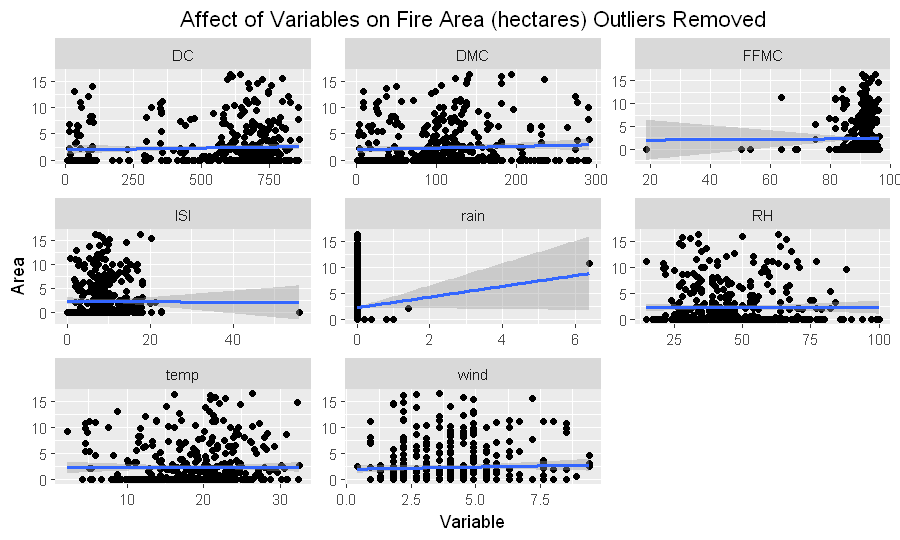

In [101]:
# create a dataframe filtered by area values removing outliers (less than or equal to 16.425)
df_long_remove_outliers <- df_long %>% 
  filter(area <= outliers)

# create a scatter plot showing the relationship between the variables and filtered area
df_long_remove_outliers %>%
  ggplot(aes(x = value, y = area)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Affect of Variables on Fire Area (hectares) Outliers Removed',
    x = 'Variable',
    y = 'Area'
  ) + 
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

Removing outliers shows no correlation between variables and area.



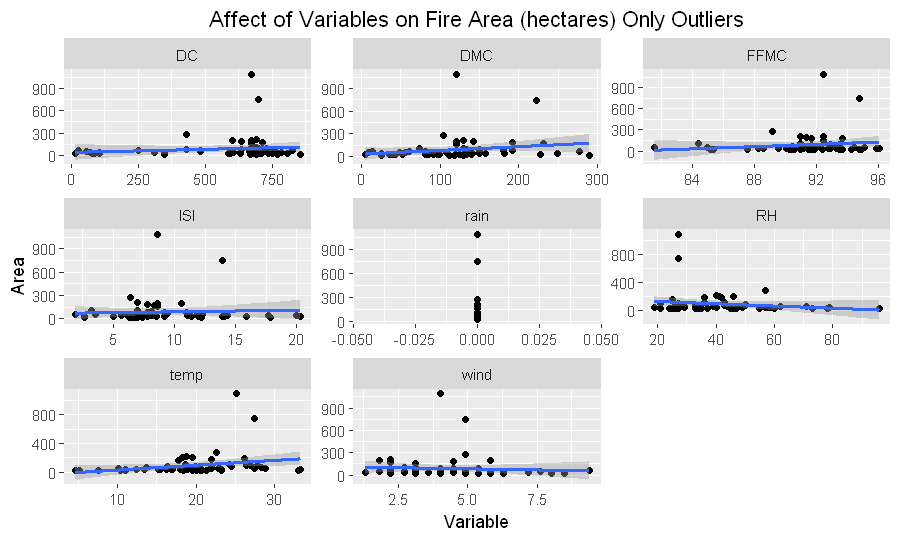

In [102]:
# create a dataframe filtered by area values with only outliers (above 16.425)
df_long_only_outliers <- df_long %>% 
  filter(area > outliers)

# create a scatter plot showing the relationship between the variables and filtered area
df_long_only_outliers %>%
  ggplot(aes(x = value, y = area)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Affect of Variables on Fire Area (hectares) Only Outliers',
    x = 'Variable',
    y = 'Area'
  ) + 
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

Data with only outliers shows no strong correlation between variables and area.



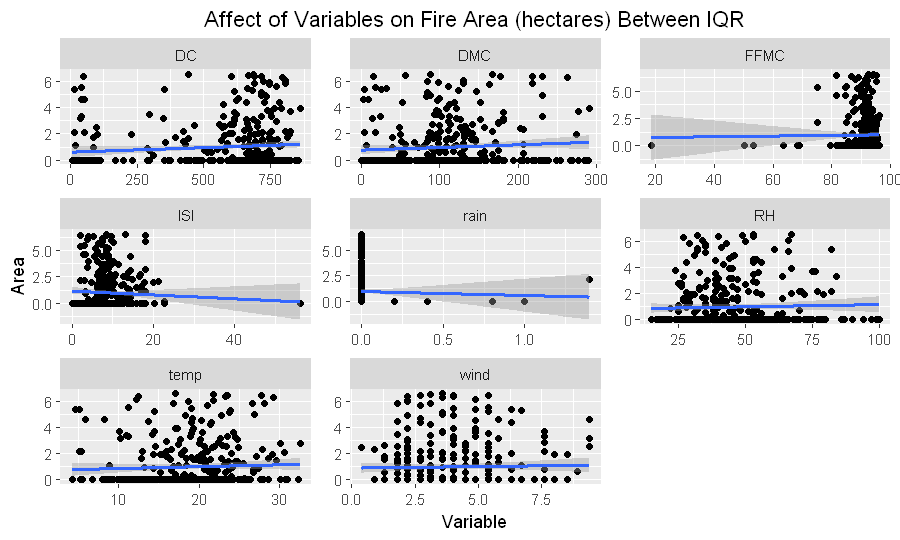

In [103]:
# create a dataframe filtered by area values between the interquartile range
df_long_between_iqr <- df_long %>% 
  filter(area <= 6.57)

# create a scatter plot showing the relationship between the variables and filtered area
df_long_between_iqr %>%
  ggplot(aes(x = value, y = area)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  facet_wrap(vars(variable), scales = 'free') +
  labs(
    title = 'Affect of Variables on Fire Area (hectares) Between IQR',
    x = 'Variable',
    y = 'Area'
  ) + 
  theme(legend.position='none', plot.title=element_text(hjust=0.5))

Data between the interquartile range shows no strong correlation between the variables and area.

## Conclusion 

* Rain has no relationship with the frequency of forest fires.
* All other variables are increased when the frequency of fires increases. 
* All variables show almost zero or very weak correlation with area. 
* Therefore, the assumption that area may be used to describe the severity or intensity of forest fires is likely false. 
